In [2]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle


import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
from featexlib import Debug as dbug
from featexlib import *


x_load.shape = (5000, 256, 256, 3) , y_load.shape = (5000, 256, 256)
Show first 4 images of x,y:


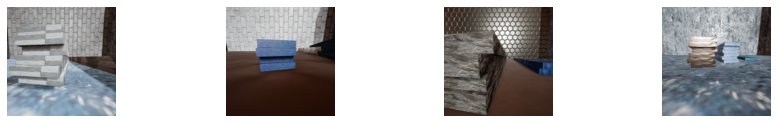

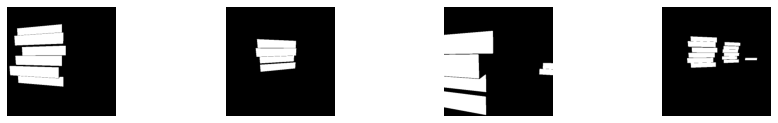

In [3]:
###Load data
x_load, y_load = Image_generator.load_data(save_dir = "../../Data/billid/training_data/", name="ndds_256x256_5000_2")

print("===================================")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
print("Show first 4 images of x,y:")
dbug.show_images_list(x_load[:4], col_number = 4)
dbug.show_images_list(y_load[:4], col_number = 4)

In [4]:
###Split data to test and train
n_offset = 0
n_train = 4900
n_test = 100
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
pic_ch = x_load.shape[3] if len(x_load.shape)>3 else 1
num_classes = 1

###Get X train and test
x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]
y_train, y_test = y_load[n_offset:n_offset+n_train], y_load[n_offset+n_train:n_offset+n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load

===============Data is ready====================
Shape X,Y for train: (4900, 256, 256, 3) (4900, 256, 256)
Shape X,Y for test:  (100, 256, 256, 3) (100, 256, 256)


In [5]:
###Reshape and then rescale dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
y_train = y_train/255
y_test = y_test/255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4900, 196608) (4900, 256, 256) (100, 196608) (100, 256, 256)


In [6]:
x_test.mean()

0.07289489246429373

In [6]:
###Export scaler
pickle.dump(scaler, open('../../models/scalers/billid_256x256_unet_scaler_v_test_1.pkl','wb'))

###Load scaler
#scaler = pickle.load(open('models/scalers/dig4_256x256_unet_acc09886_scaler.pkl','rb'))

In [23]:
###Load scaler
##NOT USED
scaler = pickle.load(open('models/scalers/billid_256x256_unet_scaler_v_test_1.pkl','rb'))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
x_test.mean()

0.08819292720144985

In [7]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype('float32').reshape(-1,pic_h,pic_w,1)
xs = x_train.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.reshape(-1,pic_h,pic_w,1)
xs_test = x_test.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)

###Clear memory
#del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(4900, 256, 256, 3) (4900, 256, 256, 1) (100, 256, 256, 3) (100, 256, 256, 1)


In [10]:
#Model 1
#Prepare model 256,256 big

def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [17]:
#Model 2
#Prepare model 256,256 small

def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.2)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.2)(conv5)

    up6 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [8]:
#Model 3
#Prepare model transfer-learned VGG16

K.clear_session()
def unet(pretrained_weights = None,input_size = (256,256,3), full_train=False):
    VGG16_weight = "../../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(1,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])

    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

In [9]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
model.fit(xs, ys, batch_size=10, epochs=5)

Epoch 1/5


In [10]:
#fit model for big data

checkpointer = tf.keras.callbacks.ModelCheckpoint('../../models/billid_256x256_unet_vgg16.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,256,256,3)
        y_input = y[i].reshape(1,256,256,1)
        yield (X_input,y_input)
        
model.fit_generator(GenerateInputs(xs,ys),epochs=1,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=20,shuffle=True)

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


20/20 [==============================] - 55s 3s/step - loss: 0.9327 - accuracy: 0.7393

Epoch 00001: loss improved from inf to 0.91678, saving model to ../../models/billid_256x256_unet_vgg16.h5


In [15]:
###Save model 1 after training
model.save_weights('../../models/billid_256x256_unet_acc09852')

In [11]:
###Save model 2 after training
model.save_weights('../../models/billid_256x256_unet_small_acc08847')

In [11]:
###Save model 3 after training
model.save_weights('../../models/billid_256x256_unet_vgg16_v_01')

In [11]:
model.load_weights('../../models/billid_256x256_unet_vgg16_v_01')

In [9]:
###Continue model training
model = unet()
model.load_weights('../../models/billid_256x256_unet_vgg16_v_01')
model.summary()
#model.fit(xs, ys, batch_size=10, epochs=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

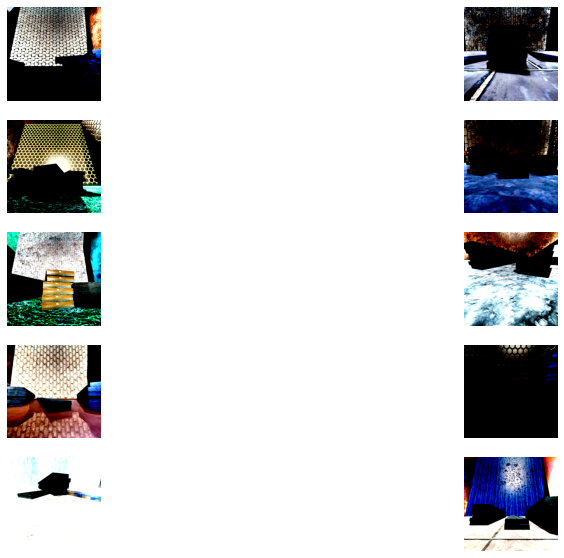

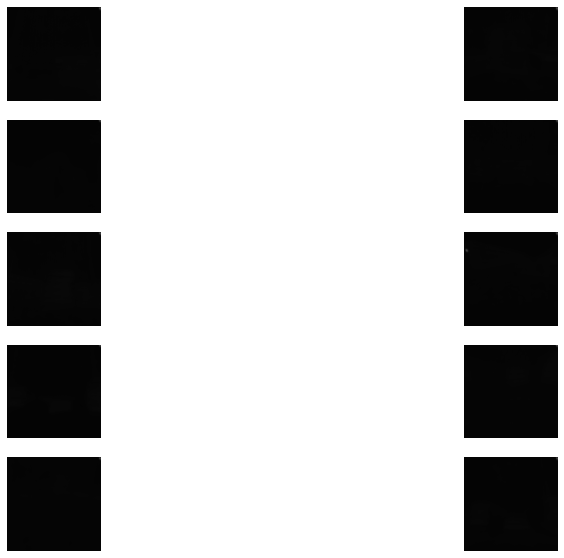

In [65]:
y_pred = model(xs[10:20]).numpy()
#dbug.show_images_list(xs_test[:10].reshape(-1,pic_h,pic_w,pic_ch), col_number = 5)
dbug.show_images_list(x_train[10:20].reshape(-1,pic_h,pic_w,pic_ch), col_number = 2, height = 2)
dbug.show_images_list(y_pred.reshape(-1,pic_h,pic_w), col_number = 2, height = 2)

-0.8357291
1.3126495


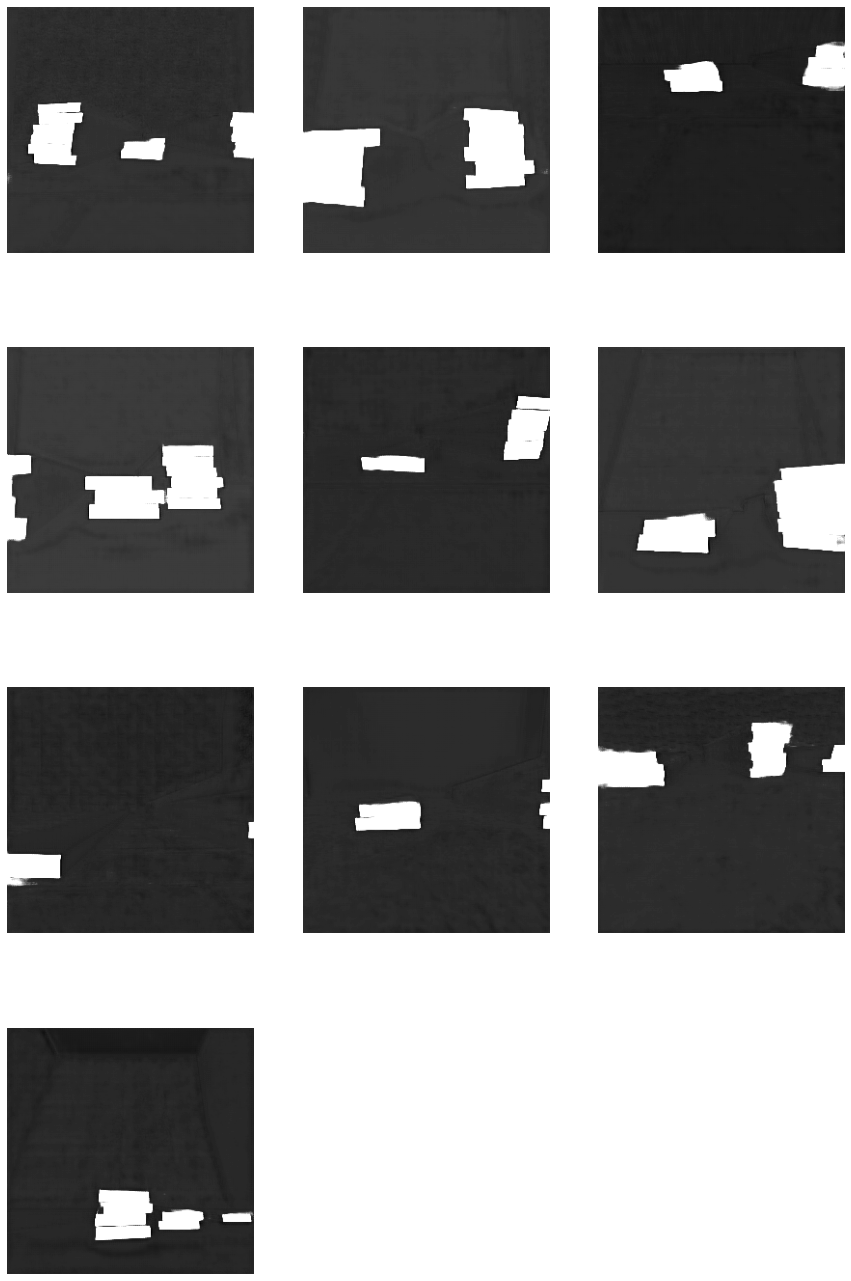

In [12]:

y_pred = model(xs_test[40:50]).numpy()
print(y_pred.mean())
print(y_pred.std())
y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
dbug.show_images_list(y_pred.reshape(-1,pic_h,pic_w), col_number = 3, height = 6)

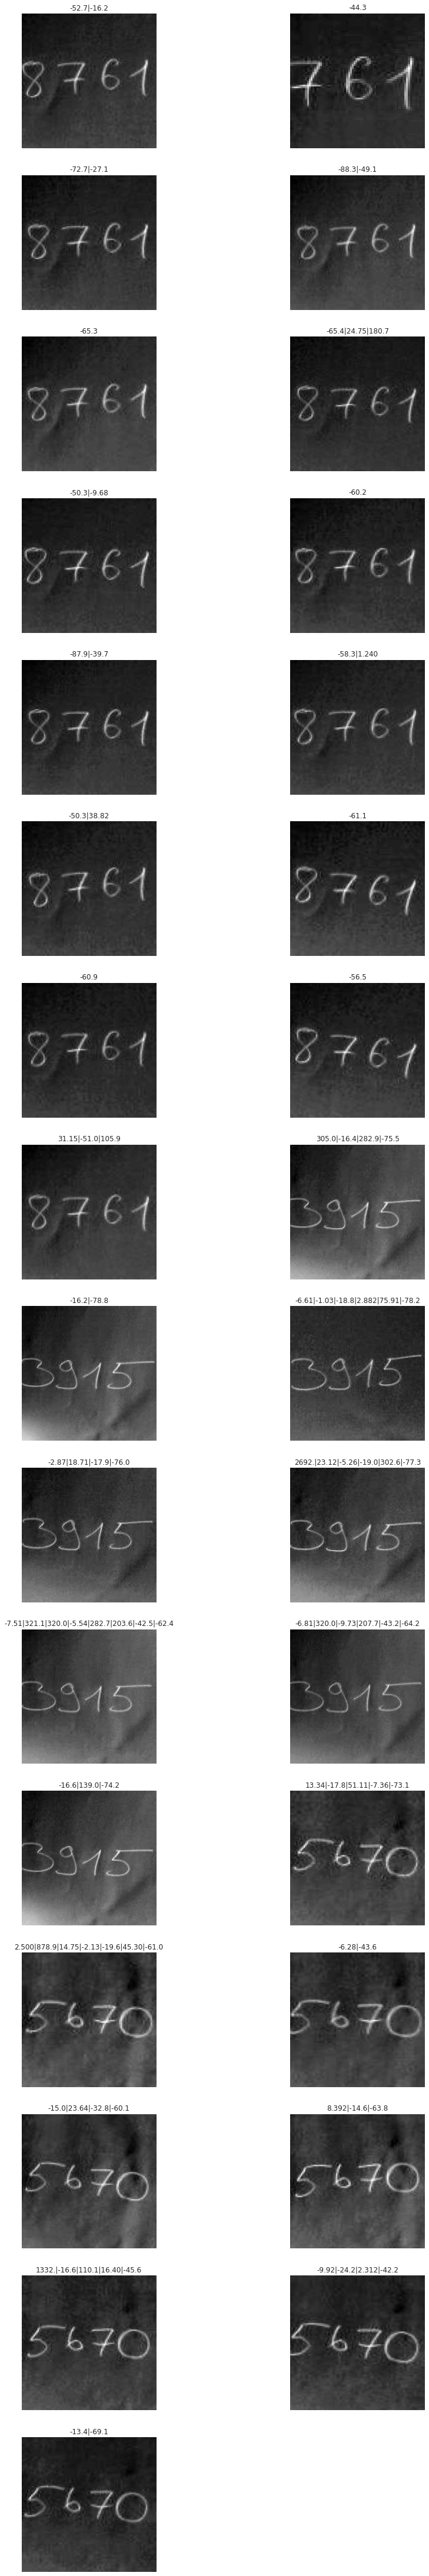

In [55]:
####Small test pipilene

import cv2 as cv
import importlib
importlib.reload(dgen)

###read images
test_images = dgen.Image_generator.load_from_folder("Data/4dig/test")
result_list = []
result_txt = []
cut_list = []

for img in test_images:
    ###read img
    #img_inp = cv.imread('Data/4dig/test/WIN_20200621_10_45_54_Pro.jpg', cv.IMREAD_UNCHANGED) 
    img_inp = img
    ###Cut image
    t,l,h,w = 0,img_inp.shape[1]-256,(img_inp.shape[0]-70),(img_inp.shape[0]-70)
    img_inp = img_inp[t:t+h,l:l+w]
    ###Convert to gray and resize
    img_gray = cv.cvtColor(img_inp, cv.COLOR_BGR2GRAY)
    img_gray = cv.resize(img_gray, (256,256), interpolation = cv.INTER_AREA) 
    ###Get inversion
    img_gray_inv = (255-img_gray)
    #Normalise image
    #mean, STD  = cv.meanStdDev(img_gray_inv)
    offset_pos = 3
    offset_neg = 3
    #img_gray = np.clip(img_gray_inv, mean - offset_neg*STD, mean + offset_pos*STD) 
    #print("Before normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    #img_gray_inv = cv.normalize(img_gray_inv, img_gray_inv, 0, 255, norm_type=cv.NORM_MINMAX)
    #print("After normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    ###Show prepared image
    ###dbug.Debug.show_image(img[:,:,[2,1,0]]) #for PIL format
    #dbug.Debug.show_image(img_gray_inv.reshape(pic_h,pic_w))
    ###rescale for NN
    img_gray_inv_scaled  = scaler.transform(img_gray_inv.reshape(-1,256*256))
    ###Make prediction
    predict = model(img_gray_inv_scaled.reshape(-1,256,256,1)).numpy()
    predict_tresh = cv.threshold(predict.reshape(256,256), 0.5, 1, cv.THRESH_BINARY)[1].astype('uint8')
    ###Find contours
    contours, hierarchy = cv.findContours(predict_tresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    result = predict.reshape(256,256)*255
    bb_list = [cv.boundingRect(contour) for contour in contours]
    if(bb_list):
        #bb = max(bb_list, key=lambda item: item[2])
        mp_find = []
        for bb in bb_list:
            cen_w = (bb[0]+bb[2]/2)
            cen_h = (bb[1]+bb[3]/2)
            mp_find.append((np.sqrt((128-cen_h)**2+(128-cen_w)**2) - 128)*1 + 1*(2688/(bb[2]*bb[3])))
        #result = cv.drawContours(result, contours[0], -1, 255, 3)
        bb = bb_list[np.argmin(mp_find)]
        cw = int((bb[0]+bb[2]/2))
        ch = int((bb[1]+bb[3]/2))
        half_size = int(np.max([bb[2],bb[3]])/2)
        pad_h = 2
        pad_w = 2
        boards = np.clip([ch-half_size, cw-half_size, ch+half_size, cw+half_size], 0, 255) 
        t,l,b,r = boards[0],boards[1],boards[2],boards[3]
        #print(t,l,b,r)
        cut_list.append(img_gray_inv[t:b,l:r])
        result = cv.rectangle(result, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), 255, 4)
        
    result_list.append(result)
    result_txt.append("|".join([str(i)[0:5] for i in mp_find]))
    
###Show result
dbug.Debug.show_images_list(cut_list,result_txt, col_number = 2, height=5)

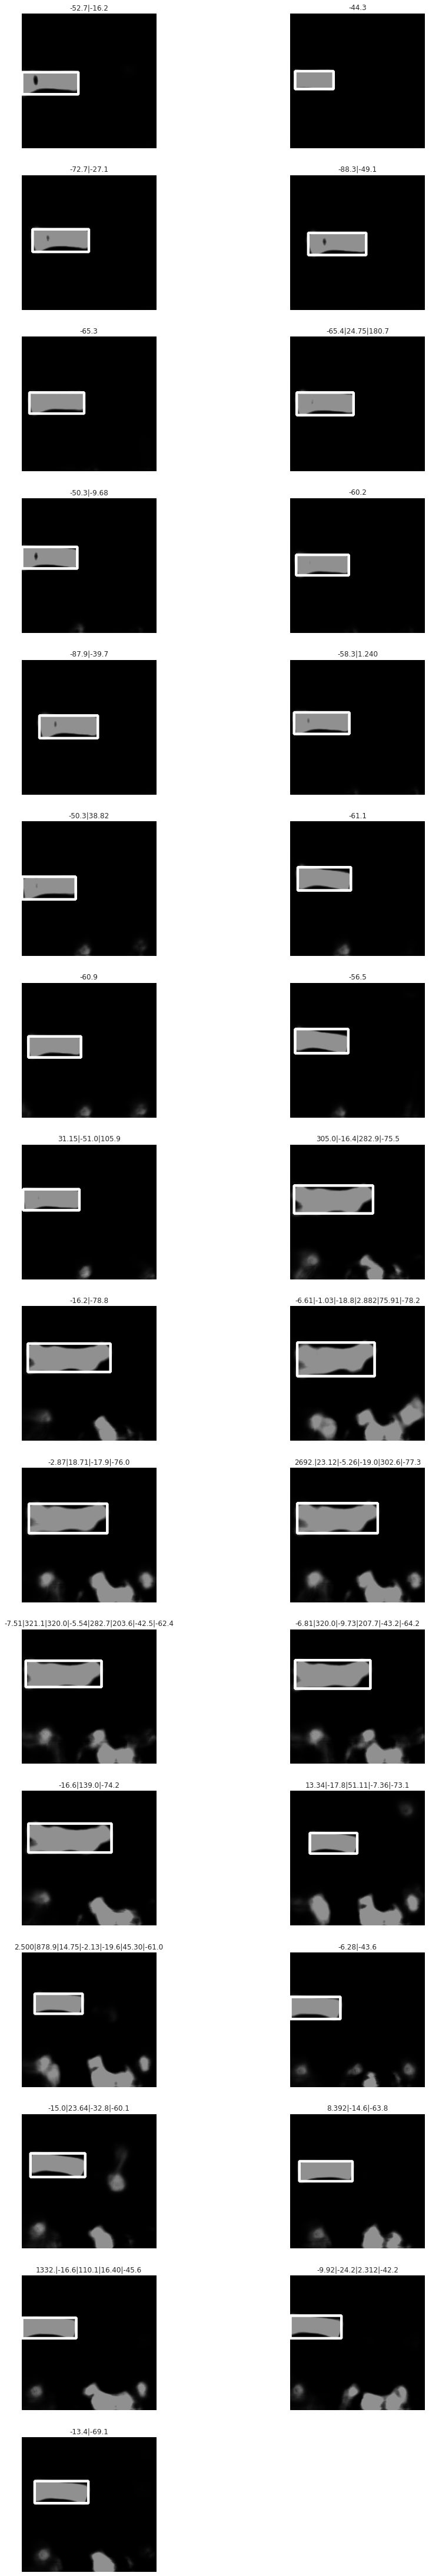

In [54]:
dbug.Debug.show_images_list(result_list,result_txt, col_number = 2, height=5)